In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy

In [3]:
# This is a temporary fix until we get the library onto PyPI
import sys, os
sys.path.append(os.path.abspath('../../lib'))
import blocksim

# Dead time reduces control performance

Let's first build a standard control loop with a disturbance.

<img src='../../assets/standard_feedback.png' width="60%">

We'll use the system and simulate the control performance with and without deadtime.
$K_m=G_c=G_m=1$ and $$G_p = \frac{e^{\theta s}}{(5s + 1)(3s + 2)}$$

In [4]:
inputs = {'ysp': lambda t: 1 if t>0 else 0,
          'd': lambda t: 1 if t>40 else 0}

In [5]:
sums = {'y': ('+yu', '+yd'),
        'e': ('+ysp', '-y'),
        }

For the dead time free system, we can use a high gain PI controller

In [6]:
Gp1 = blocksim.LTI('Gp', 'p', 'yu',
                   1, numpy.convolve([5, 1], [3, 1]))

In [7]:
Gc1 = blocksim.PI('Gc', 'e', 'p',
                  3.02, 6.5)

For the system with dead time we need to detune the controller

In [8]:
Gp2 = blocksim.LTI('Gp', 'p', 'yu',
                   1, numpy.convolve([5, 1], [3, 1]), delay=2)

In [9]:
Gc2 = blocksim.PI('Gc', 'e', 'p',
                  1.23, 7)

In [10]:
Gd = blocksim.LTI('Gd', 'd', 'yd',
                   1, numpy.convolve([5, 1], [3, 1]), delay=2)

In [11]:
diagrams = [blocksim.Diagram([Gp1, Gc1, Gd], sums, inputs),
            blocksim.Diagram([Gp2, Gc2, Gd], sums, inputs)]

In [12]:
ts = numpy.linspace(0, 80, 2000)

In [13]:
outputs = []

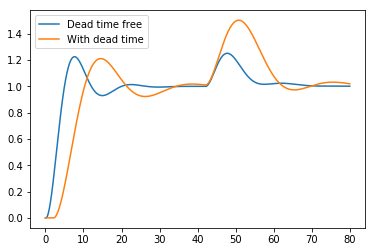

In [14]:
for diagram in diagrams:
    outputs.append(diagram.simulate(ts))
    plt.plot(ts, outputs[-1]['y'])
plt.legend(['Dead time free', 'With dead time'])

# Smith Predictor

The Smith predictor or dead time compensator uses a dead time free model to do most of the control ($\widetilde{G}^*$} and then subtracts the delayed prediction from the measurement to react only on the unhandled dynamics.

<img src="../../assets/smith.png" width="80%">

In [15]:
sums = {'y': ('+yd', '+yu'),
        'y-ytilde2': ('-ytilde2', '+y'),
        'e': ('+ysp', '-y-ytilde2'),
        'eprime': ('+e', '-ytilde1'),
       }

We'll use the dead time containing model from before

In [16]:
G = Gp2
G.name = 'G'

But the controller which was tuned on the dead time free model

In [17]:
Gc = Gc1
Gc.inputname = 'eprime'

In [18]:
Gtildestar = blocksim.LTI('Gtildestar', 'p', 'ytilde1',
                          1, numpy.convolve([5, 1], [3, 1]))

In [19]:
delay = blocksim.Deadtime('Delay', 'ytilde1', 'ytilde2', 2)

In [20]:
blocks = [Gc, G, Gd, Gtildestar, delay]

In [21]:
diagram = blocksim.Diagram(blocks, sums, inputs)
diagram

PI: eprime →[ Gc ]→ p
LTI: p →[ G ]→ yu
LTI: d →[ Gd ]→ yd
LTI: p →[ Gtildestar ]→ ytilde1
Deadtime: ytilde1 →[ Delay ]→ ytilde2

In [22]:
outputs.append(diagram.simulate(ts))

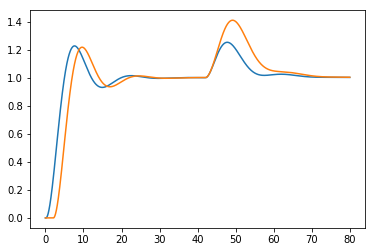

In [23]:
plt.plot(ts, outputs[0]['y'])
plt.plot(ts, outputs[2]['y'])

We see that the Smith Predictor gives us almost the same performance as the dead time free system, but that it cannot compensate for the delay in the disturbance output because it doesn't have an undelayed measurement of it.